In [1]:
from pickle import load
import os
import torch
from utils import SimplexEnvironment

MDP = load(open(os.path.join("data", "mdps", "small" ,"small_mdp.bin"), 'rb'))
t = torch.from_numpy(MDP.get_transitions()).to(torch.float32)

100%|██████████| 10/10 [00:00<00:00, 1665.99it/s]


In [2]:
print( MDP.S, MDP.A, MDP.d)

100 10 3


We will use a Neural Network To approximate the embedding functions of our MDP.

In [3]:
import torch.nn as nn
import torch.nn.functional as F
import torch

In [4]:

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [5]:
class Net(nn.Module): 
    def __init__(self, states, actions, d):
        super(Net, self).__init__()
        self.states = states
        self.actions = actions
        self.d = d
        self.device = 'cpu'
    
        self.l1 = nn.Linear(self.states + self.actions, 120)  #First Linear layers, Receives concat onehot enconding of state-action pair
        self.l2 = nn.Linear(120, 20)
        self.bn1 = nn.BatchNorm1d(num_features=1)
        self.embedding = nn.Linear(20, self.d)

        self.mu_weights = nn.Parameter(torch.full((self.d, self.states), 1/self.states))
    
    def to(self, device):
        self.device = device
        super(Net, self).to(device)

    def encode_input(self, s, a):
         """
        # Parameters:
        s: State id or list like of state ids between 0 and self.states
        a: Action id or list like of actions ids between 0 and self.actions

        If s and a are list-like, both need to be the same lenght
         """
         input_len = len(s) if hasattr(s, '__len__') else 1
         actions_len = len(a) if hasattr(a, '__len__') else 1
         assert input_len == actions_len, f"The input lenghts do not coincide. Input States: {input_len}; Input Actions: {actions_len}"

         s_hot = F.one_hot(s.view(input_len, 1), self.states).to(torch.float32)
         a_hot = F.one_hot(a.view(input_len, 1), self.actions).to(torch.float32)
         x = torch.cat((s_hot, a_hot), dim=-1)# Concat one hot vectors 
         return x.to(self.device)

    def enconde_output(self, s):
        input_len = len(s) if hasattr(s, '__len__') else 1
        return F.one_hot(s.view(input_len, 1), self.states).to(torch.float32)


    def phi(self, s, a):
        """
        # Parameters:
        s: State id or list like of state ids between 0 and self.states
        a: Action id or list like of actions ids between 0 and self.actions

        If s and a are list-like, both need to be the same lenght
         """
        
        x = self.encode_input(s, a) 
        x = F.relu(self.l1(x))
        x = F.leaky_relu(self.l2(x))
        x = self.bn1(x)
        x = F.softmax(self.embedding(x), dim=-1) # Apply softmax row wise

        return x # This should be of shape (batch_size, 1, d)

    def mu(self):
        return F.softmax(self.mu_weights, dim=-1)

    def forward(self, s, a):
        """
        # Parameters:
        s: State id or list like of state ids between 0 and self.states
        a: Action id or list like of actions ids between 0 and self.actions

        If s and a are list-like, both need to be the same lenght
        """
        x = self.phi(s, a)
        soft_mu = self.mu()

        # We use bradcasting in here so the same parameters are used for every element of the batch
        x = torch.matmul(x, soft_mu) # Mat multiplication of (batch_size, 1, d) @ (d, states) --> (batch_size, 1, states) # Distribution over states

        return x.view(-1, self.states)

    def phi_a_matrix(self, a):
        """Calculates the transition kernes induces by phi when one action a is fixed.
        # Parameters:
        a: Action id between 0 and self.actions - 1
         """
        actions_list = a.repeat(self.states)
        state_list = torch.arange(0, (self.states), dtype=int)

        with torch.no_grad():
            phi_a_batch = self.phi(state_list, actions_list).view(self.states, self.d) # This should be of shape (states, d)

            return torch.matmul(phi_a_batch, self.mu()) # Should be size (states, states)


net = Net(MDP.S, MDP.A, MDP.d)

In [6]:
net.parameters

<bound method Module.parameters of Net(
  (l1): Linear(in_features=110, out_features=120, bias=True)
  (l2): Linear(in_features=120, out_features=20, bias=True)
  (bn1): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (embedding): Linear(in_features=20, out_features=3, bias=True)
)>

In [7]:
# net.phi_a_matrix(torch.tensor(1)).size()

In [8]:
# torch.isclose(torch.ones((net.states)), torch.sum(net.phi_a_matrix(torch.tensor(1)), dim=-1), 0.001)

In [9]:
from pickle import load

train_path = load(open(os.path.join("data", "mdps", "small" ,"small_mdp_path_train.bin"), 'rb'))
test_path = load(open(os.path.join("data", "mdps", "small" ,"small_mdp_path_test.bin"), 'rb'))

print(len(train_path)/ (len(train_path) + len(test_path)))


0.7


In [10]:
from torch.utils.data import Dataset, DataLoader

class ListDataset(Dataset):
    def __init__(self, l, batch_size=4) -> None:
        super().__init__()
        self.l = l
        self.batch_size = batch_size

    def __len__(self):
        return len(self.l)

    def __getitem__(self, idx):
        return (self.l[idx][:2]), self.l[idx][2]

    def __iter__(self):
        l0, l1, l2 = [], [], []
        for i in self.l:
            l0.append(i[0]); l1.append(i[1]); l2.append(i[2])
            if len(l0) == self.batch_size:
                yield torch.tensor(l0), torch.tensor(l1), torch.tensor(l2)
                l0, l1, l2 = [], [], []
        

batch_size = 64
train_dataset = ListDataset(train_path, batch_size=batch_size)

In [11]:
# bat = next(iter(train_dataset))

In [12]:
# bat

In [13]:
# forw = net.forward(bat[0], bat[1])
# forw.size()

In [14]:
import torch.optim as optim

criterion = nn.NLLLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
loder_len = len(train_path)

In [15]:
net.to(device)

Training Loop

In [16]:
%%time
from tqdm import tqdm

losses = []
avg_losses = []
batch_losses = []
frob_diff = []
t = torch.from_numpy(MDP.get_transitions())
for epoch in range(3):  # loop over the dataset multiple times

    running_loss = 0.0
    avg_loss = 0.0
    with tqdm(enumerate(train_dataset, 0), total=(loder_len // batch_size)) as tepoch:
        for i, data in tepoch:
            tepoch.set_description(f"Epoch {epoch}.  ")

            # get the inputs; data is a list of [inputs, labels]
            input_states, input_actions, labels = data[0].to(device), data[1].to(device), data[2].to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = torch.log(net(input_states, input_actions))
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            losses.append(loss.item())
            running_loss += loss.item()

            if i % 10 == 9:    # print every 10 mini-batches
                tepoch.set_postfix(loss=f'{running_loss / 10:.3f}')
                batch_losses.append(running_loss / 10)
                running_loss = 0.0

            if i % 50 == 49:
                with torch.no_grad():
                    m0 = net.phi_a_matrix(torch.tensor(0)).detach().unsqueeze(0).to("cpu")
                    for i in range(1, MDP.A):
                        ma = net.phi_a_matrix(torch.tensor(0)).detach().unsqueeze(0).to("cpu")
                        m0 = torch.cat((m0, ma), dim=0)
                        
                    frob = torch.norm((m0-t))
                    frob_diff.append(frob)
                    

                    
        
        avg_losses.append(running_loss / (loder_len // batch_size))



print('Finished Training')

Epoch 2.  : 100%|██████████| 4533/4533 [01:11<00:00, 63.42it/s, loss=4.189] 

Finished Training
CPU times: total: 6min 56s
Wall time: 2min 28s


Text(0, 0.5, 'NLLLoss')

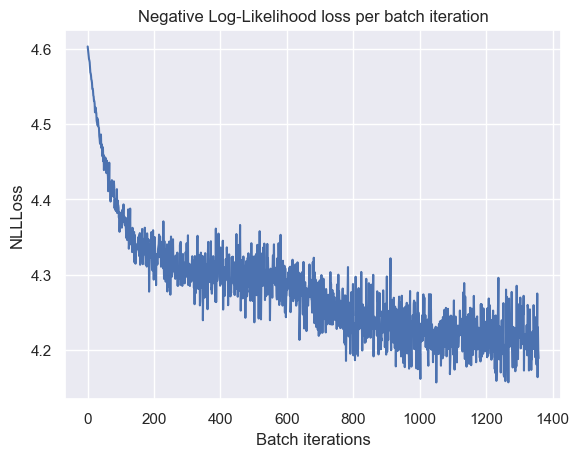

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()
plt.plot(batch_losses)
plt.title("Negative Log-Likelihood loss per batch iteration")
plt.xlabel("Batch iterations")
plt.ylabel("NLLLoss")

Next will be the behaviour of our net in term of difference of frobenius norm. This can help us do a relatively easy comparative between this approach and others like sGS_ADMM_MDPs

Text(0, 0.5, '$\\sum_{a \\in \\mathcal{A}}||X_a - M_a||_{fb}$')

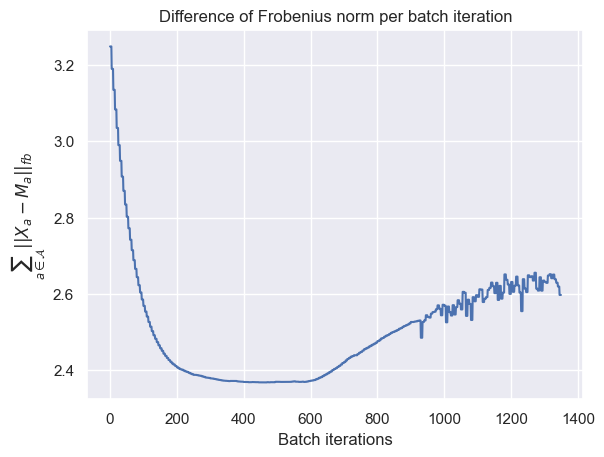

In [18]:
frob_diff_batch = [i for i in frob_diff for j in range(5)]
plt.plot(frob_diff_batch)
plt.title("Difference of Frobenius norm per batch iteration")
plt.xlabel("Batch iterations")
plt.ylabel("$\sum_{a \in \mathcal{A}}||X_a - M_a||_{fb}$")

In [19]:
m0 = net.phi_a_matrix(torch.tensor(0)).detach().unsqueeze(0).to("cpu")
for i in range(1, MDP.A):
    ma = net.phi_a_matrix(torch.tensor(0)).detach().unsqueeze(0).to("cpu")
    m0 = torch.cat((m0, ma), dim=0)
m0.size()

torch.Size([10, 100, 100])

In [20]:
m0_real = torch.from_numpy(MDP.get_transitions())
m0_real.size()

100%|██████████| 10/10 [00:00<00:00, 4995.60it/s]


torch.Size([10, 100, 100])

In [21]:
torch.norm((m0-m0_real))

tensor(3.4184, dtype=torch.float64)

In [40]:
other =  SimplexEnvironment(states=100, actions=10, bell_rank=3)
t_other = torch.from_numpy(other.get_transitions())
torch.norm((t-t_other))

100%|██████████| 10/10 [00:00<00:00, 9984.06it/s]


tensor(4.8705, dtype=torch.float64)

torch.norm((t-t_other))